##### Copyright 2019 The TensorFlow Authors.

In [209]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Deep Convolutional Generative Adversarial Network

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/dcgan">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/dcgan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to generate images of handwritten digits using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras) with a `tf.GradientTape` training loop.

## What are GANs?
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A *generator* ("the artist") learns to create images that look real, while a *discriminator* ("the art critic") learns to tell real images apart from fakes.

![A diagram of a generator and discriminator](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan1.png?raw=1)

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

![A second diagram of a generator and discriminator](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan2.png?raw=1)

This notebook demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

To learn more about GANs, we recommend MIT's [Intro to Deep Learning](http://introtodeeplearning.com/) course.

### Setup

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.4.1'

In [3]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-b6f_1t4o
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-b6f_1t4o
     |████████████████████████████████| 1.0MB 17.4MB/s 
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0af7fffde9d304410f808c8752cfe519ba107ca33_-cp37-none-any.whl size=147328 sha256=bbdce293657ec1aab7c83e7abdd0c5c66d975248b55df6544fdf0b6e0c748f16
  Stored in directory: /tmp/pip-ephem-wheel-cache-kk3dt2ev/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import pandas as pd
from IPython import display
import cv2 
from PIL import Image
from skimage import color
from skimage import io
from google.colab import files
from collections import Counter
import scipy.io as scio
from scipy import stats

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

dataset lien : 
https://edx.netl.doe.gov/dataset/sofc-microstructures-hsu-epting-mahbub-jps-2018

In [5]:
from google.colab import drive #link to the dataset in google drive
drive.mount('/content/drive')

Mounted at /content/drive


(224, 224)

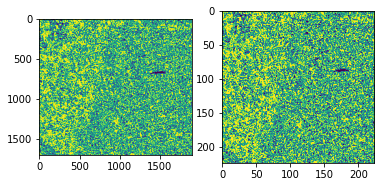

In [215]:
#example ----make img rgb2grey and reshape
#test = cv2.imread("/content/drive/My Drive/Colab Notebooks/cathode_segmented/cathode_segmented_tiff_z001.tif")
img = color.rgb2gray(io.imread("/content/drive/My Drive/Colab Notebooks/anode_segmented/anode_segmented_tiff_z001.tif"))
crop_size = (224, 224)
img_shape = cv2.resize(img, crop_size, interpolation = cv2.INTER_CUBIC)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(img_shape)
img_shape.shape

In [6]:
#read the images in dic as a arrary 3D
def read_data(train_images,dicname,crop_size):
  i = 0 
  for filename in os.listdir(r"/" + dicname): 
      img = color.rgb2gray(io.imread("/" + dicname + "/" + filename,plugin='matplotlib'))        #rgb2grey
      img_shape = cv2.resize(img, crop_size, interpolation = cv2.INTER_CUBIC) #reshape
      train_images[i,:,:] = img_shape
      i = i + 1
  return train_images

In [217]:
#make the dataset for all images
dicname1 = "content/drive/My Drive/Colab Notebooks/cathode_segmented"
dicname2 = "content/drive/My Drive/Colab Notebooks/anode_segmented"
files=os.listdir("/" + dicname2) # change the dic name here
num_img = len(files)
train_images = np.zeros(shape=(num_img,224,224))
crop_size = (224, 224)
train_images = read_data(train_images,dicname2,crop_size) # change the dic name here

[[  0. 255.   0. ... 255. 114. 255.]
 [  0. 255. 255. ... 255. 128. 255.]
 [  0. 255. 118. ...  54. 255. 128.]
 ...
 [128. 128.   0. ... 128.   0.   0.]
 [  1. 255.   0. ... 131. 128. 128.]
 [255. 255. 184. ...   1. 128. 128.]]


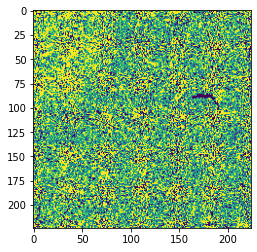

In [218]:
train_images.shape
plt.figure()
plt.imshow(train_images[4,:,:])
print(train_images[20,:,:])

In [219]:
train_images = train_images.reshape(train_images.shape[0], 224, 224, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [220]:
BUFFER_SIZE = num_img
BATCH_SIZE = 12         #change here

In [221]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [222]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization()) # 是将分散的数据统一的一种做法, 也是优化神经网络的一种方法
    model.add(layers.LeakyReLU()) #激活函数   #输入层

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))#5，5是窗
    assert model.output_shape == (None, 14, 14, 128)#128 变成这里128，步长为1，7-7，步长为2，7-14
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(4, 4), padding='same', use_bias=False))
    assert model.output_shape == (None, 56, 56, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(4, 4), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 224, 224, 1)

    return model

Use the (as yet untrained) generator to create an image.

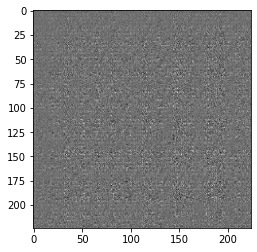

In [223]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

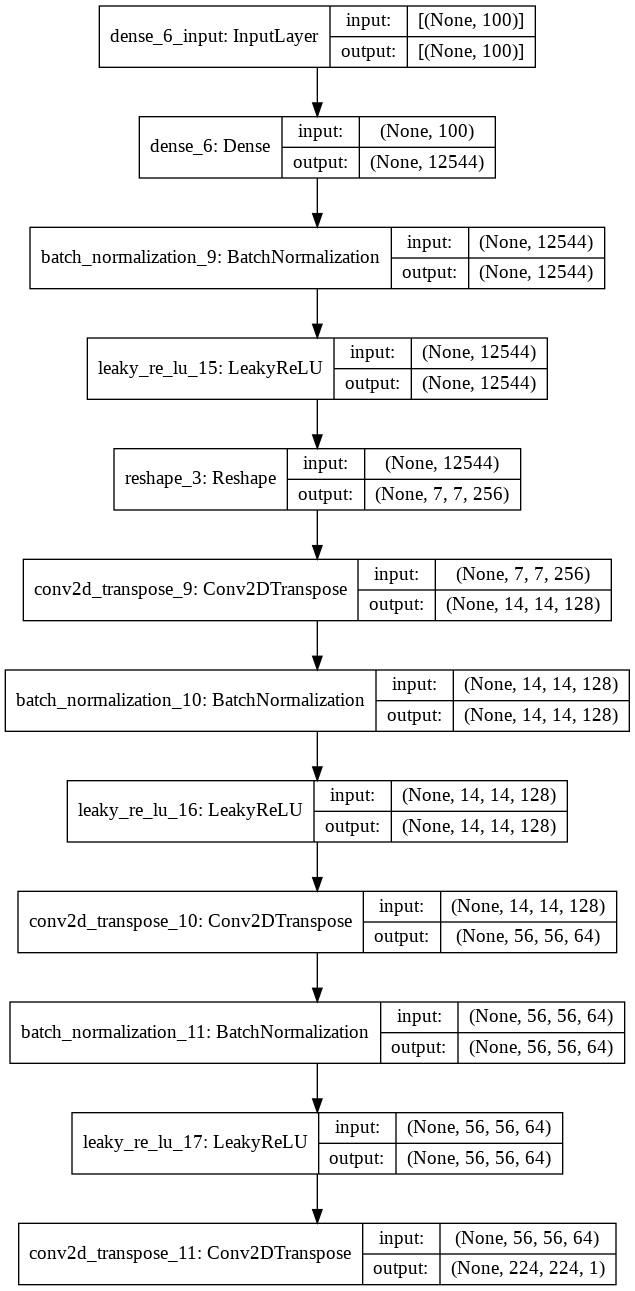

In [224]:
tf.keras.utils.plot_model(generator,show_shapes=True)

### The Discriminator

The discriminator is a CNN-based image classifier.

In [225]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(4, 4), padding='same',
                                     input_shape=[224, 224, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(8, 8), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [226]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-1.6657723e-05]], shape=(1, 1), dtype=float32)


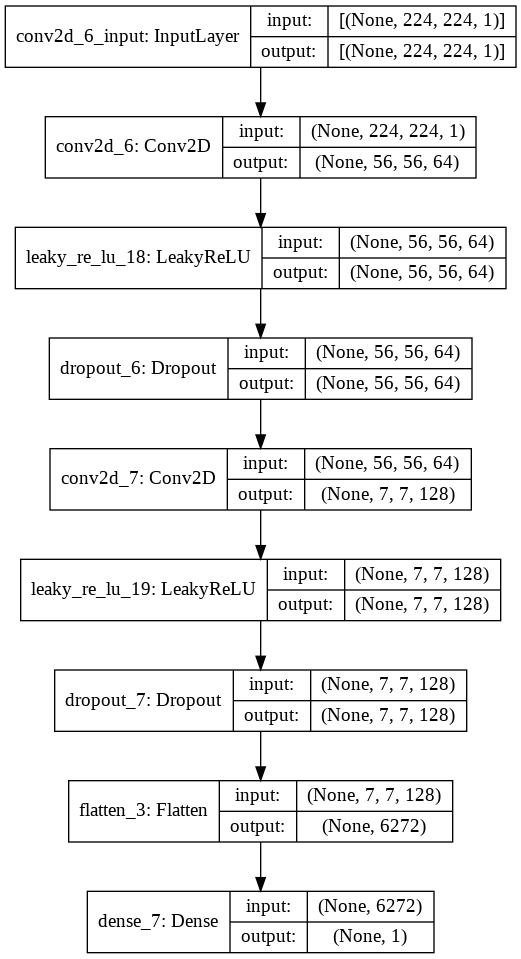

In [227]:
tf.keras.utils.plot_model(discriminator,show_shapes=True)

## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [228]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [229]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [230]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [231]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [232]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [233]:
EPOCHS = 10  # change here
noise_dim = 100
num_examples_to_generate = 1

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [234]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [235]:
def train(dataset, epochs, num_img):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
    # Produce images for the GIF as we go
    #display.clear_output(wait=True)
    #generate_images(generator,
                             #epoch + 1,
                             #seed)
    # Save the model every 5 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    display.clear_output(wait=True)
    print ('Time for train epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  for i in range(num_img):
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    display.clear_output(wait=True)
    generate_and_save_images(generator,i,seed)
    print("generate no.{} image".format(i)) 

**Generate and save images**


In [236]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(5,5))

  for i in range(predictions.shape[0]):
      plt.subplot(1, 1, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('/content/drive/My Drive/Colab Notebooks/syn_anode_size12/image_at_epoch_{:04d}.png'.format(epoch),bbox_inches = 'tight',pad_inches = 0.0) # change here syn_anode_size3
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

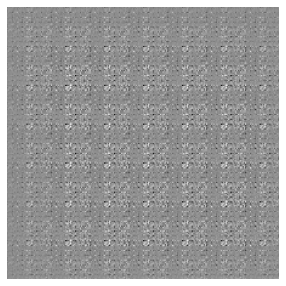

generate no.123 image


In [237]:
train(train_dataset, EPOCHS, num_img)

Restore the latest checkpoint.

In [50]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# morphological properties

## volume fraction

In [73]:
#calculate the volume fraction of the image
def surface_greyscale(img): 
  counter = Counter(img.ravel())
  black = counter[0]
  grey = counter[128]
  white = counter[255]
  return black,grey,white

In [74]:
def volume_fraction(black,grey,white): 
  summer = black + grey + white
  return round(black/summer,3), round(grey/summer,3), round(white/summer,3)

In [75]:
#calculate the volume fraction of the image in a dic
def volume_fraction_hist(vf,dicname,crop_size):
  i = 0 
  fac = np.zeros(shape=(3))
  for filename in os.listdir(r"/" + dicname): 
      img = color.rgb2gray(io.imread("/" + dicname + "/" + filename))        #rgb2grey
      img_shape = cv2.resize(img, crop_size, interpolation = cv2.INTER_CUBIC) #reshape
      fac = surface_greyscale(img_shape)
      fac = volume_fraction(fac[0],fac[1],fac[2])
      vf[i,:] = fac
      i = i + 1
  return vf

In [108]:
def plot_box(vf,descrire):

  data = {
  'Black(real)': vf[:,0],
  'Black(fake)': vf[:,3],
  'Grey(real)': vf[:,1],
  'Grey(fake)': vf[:,4],
  'White(real)': vf[:,2],
  'White(fake)': vf[:,5]
    }
  df = pd.DataFrame(data)
  df.plot.box(title=descrire)
  plt.grid(linestyle="--", alpha=0.3)
  plt.show()

In [77]:
#because the generate image (0-1) turn into 0-255 and only 0 128 255
def threshold_and_0_255 (img):
  img = img*255
  img = np.trunc(img)
  threshold1 = 120
  threshold2 = 150
  a = img.shape
  for i in range(a[0]):
    for j in range(a[1]):
      if img[i,j]<threshold1:
        img[i,j] = 0
      elif img[i,j]>=threshold1 and img[i,j]<=threshold2 :
        img[i,j] = 128
      elif img[i,j]>threshold2:
        img[i,j] = 255
  return img

In [78]:
#calculate the volume fraction of the image in a dic
def volume_fraction_hist_fake(vf,dicname,crop_size):
  i = 0 
  fac = np.zeros(shape=(3))
  for filename in os.listdir(r"/" + dicname): 
      img = color.rgb2gray(io.imread("/" + dicname + "/" + filename))        #rgb2grey
      img_shape = cv2.resize(img, crop_size, interpolation = cv2.INTER_CUBIC) #reshape
      img_shape = threshold_and_0_255(img_shape)
      fac = surface_greyscale(img_shape)
      fac = volume_fraction(fac[0],fac[1],fac[2])
      vf[i,:] = fac
      i = i + 1
  return vf

In [79]:
dicname1 = "content/drive/My Drive/Colab Notebooks/anode_segmented" #real image
dicname2 = "content/drive/My Drive/Colab Notebooks/syn_anode_size3" #fake image
dicname3 = "content/drive/My Drive/Colab Notebooks/syn_anode_size4" #fake image
dicname4 = "content/drive/My Drive/Colab Notebooks/syn_anode_size6" #fake image
dicname5 = "content/drive/My Drive/Colab Notebooks/syn_anode_size10" #fake image
dicname6 = "content/drive/My Drive/Colab Notebooks/syn_anode_size12" #fake image

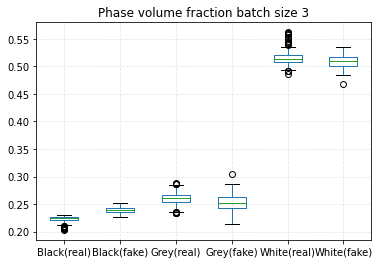

In [80]:
#plot volume fraction box of the images(orininal or syn images)
files1=os.listdir("/" + dicname1) 
num_img1 = len(files1)
files2=os.listdir("/" + dicname2) 
num_img2 = len(files2)
vf1 = np.zeros(shape=(num_img1,3))
vf2 = np.zeros(shape=(num_img2,3))
vf = np.zeros(shape=(num_img2,6))
crop_size = (224, 224)
vf1 = volume_fraction_hist(vf1,dicname1,crop_size)
vf2 = volume_fraction_hist_fake(vf2,dicname2,crop_size)
vf = np.hstack((vf1,vf2))
descrire = "Phase volume fraction batch size 3"
plot_box(vf,descrire)

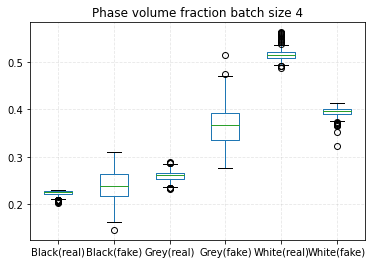

In [81]:
#plot volume fraction box of the images(orininal or syn images)
files1=os.listdir("/" + dicname1) 
num_img1 = len(files1)
files3=os.listdir("/" + dicname3) 
num_img3 = len(files3)
vf1 = np.zeros(shape=(num_img1,3))
vf3 = np.zeros(shape=(num_img3,3))
vf = np.zeros(shape=(num_img3,6))
crop_size = (224, 224)
vf1 = volume_fraction_hist(vf1,dicname1,crop_size)
vf3 = volume_fraction_hist_fake(vf3,dicname3,crop_size)
vf = np.hstack((vf1,vf3))
descrire = "Phase volume fraction batch size 4"
plot_box(vf,descrire)

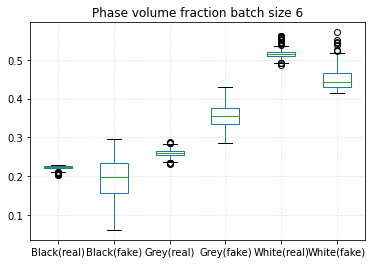

In [82]:
#plot volume fraction box of the images(orininal or syn images)
files1=os.listdir("/" + dicname1) 
num_img1 = len(files1)
files4=os.listdir("/" + dicname4) 
num_img4 = len(files4)
vf1 = np.zeros(shape=(num_img1,3))
vf4 = np.zeros(shape=(num_img4,3))
vf = np.zeros(shape=(num_img4,6))
crop_size = (224, 224)
vf1 = volume_fraction_hist(vf1,dicname1,crop_size)
vf4 = volume_fraction_hist_fake(vf4,dicname4,crop_size)
vf = np.hstack((vf1,vf4))
descrire = "Phase volume fraction batch size 6"
plot_box(vf,descrire)

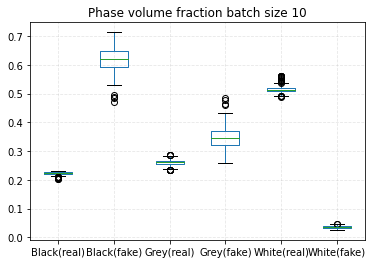

In [83]:
#plot volume fraction box of the images(orininal or syn images)
files1=os.listdir("/" + dicname1) 
num_img1 = len(files1)
files5=os.listdir("/" + dicname5) 
num_img5 = len(files5)
vf1 = np.zeros(shape=(num_img1,3))
vf5 = np.zeros(shape=(num_img5,3))
vf = np.zeros(shape=(num_img5,6))
crop_size = (224, 224)
vf1 = volume_fraction_hist(vf1,dicname1,crop_size)
vf5 = volume_fraction_hist_fake(vf5,dicname5,crop_size)
vf = np.hstack((vf1,vf5))
descrire = "Phase volume fraction batch size 10"
plot_box(vf,descrire)

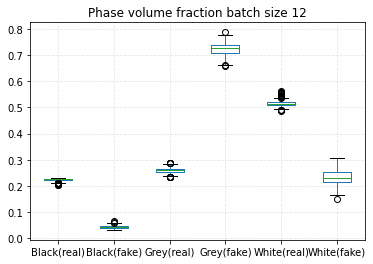

In [84]:
#plot volume fraction box of the images(orininal or syn images)
files1=os.listdir("/" + dicname1) 
num_img1 = len(files1)
files6=os.listdir("/" + dicname6) 
num_img6 = len(files6)
vf1 = np.zeros(shape=(num_img1,3))
vf6 = np.zeros(shape=(num_img6,3))
vf = np.zeros(shape=(num_img6,6))
crop_size = (224, 224)
vf1 = volume_fraction_hist(vf1,dicname1,crop_size)
vf6 = volume_fraction_hist_fake(vf6,dicname6,crop_size)
vf = np.hstack((vf1,vf6))
descrire = "Phase volume fraction batch size 12"
plot_box(vf,descrire)

In [109]:
#use t test to juge the difference of two dataset
def my_ttest(x,y,ci=0.05):
    if (len(x)>1) & (len(y)>1):
        v_test=stats.levene(x,y)
        if v_test.pvalue<0.05:
            my_equal_var=True
        else:
            my_equal_var=False

        t_test_p=stats.ttest_ind(x,y,equal_var=my_equal_var).pvalue
        if t_test_p<ci:
            print(t_test_p)
            return t_test_p
        else:
            print(t_test_p)
            return t_test_p
    else:
        return True

3.0881006292490445e-57
1.2300883727594412e-08
2.952250070710772e-08
1.637969066293825e-197
3.5798851563865314e-278


Text(0, 0.5, 't test')

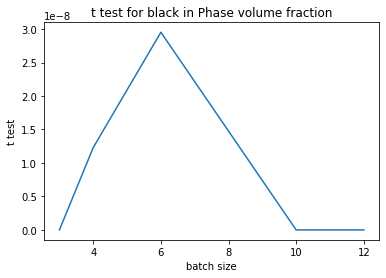

In [110]:
t_test_black = np.zeros(5)
t_test_black[0] = my_ttest(vf1[:,0],vf2[:,0])
t_test_black[1] = my_ttest(vf1[:,0],vf3[:,0])
t_test_black[2] = my_ttest(vf1[:,0],vf4[:,0])
t_test_black[3] = my_ttest(vf1[:,0],vf5[:,0])
t_test_black[4] = my_ttest(vf1[:,0],vf6[:,0])
x = [3,4,6,10,12]
plt.plot(x,t_test_black)
plt.title(u't test for black in Phase volume fraction')        
plt.xlabel('batch size')             
plt.ylabel('t test')

1.8409333019823545e-07
1.1462553248185472e-72
9.260523674841329e-88
1.5144625919450052e-62
5.345173209392862e-268


Text(0, 0.5, 't test')

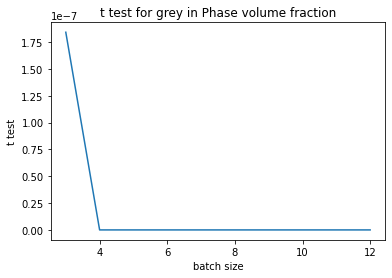

In [111]:
t_test_grey = np.zeros(5)
t_test_grey[0] = my_ttest(vf1[:,1],vf2[:,1])
t_test_grey[1] = my_ttest(vf1[:,1],vf3[:,1])
t_test_grey[2] = my_ttest(vf1[:,1],vf4[:,1])
t_test_grey[3] = my_ttest(vf1[:,1],vf5[:,1])
t_test_grey[4] = my_ttest(vf1[:,1],vf6[:,1])
x = [3,4,6,10,12]
plt.plot(x,t_test_grey)
plt.title(u't test for grey in Phase volume fraction')        
plt.xlabel('batch size')             
plt.ylabel('t test')

1.394310906171549e-05
1.4695569189455327e-158
1.290184386246706e-51
0.0
4.303726294748535e-193


Text(0, 0.5, 't test')

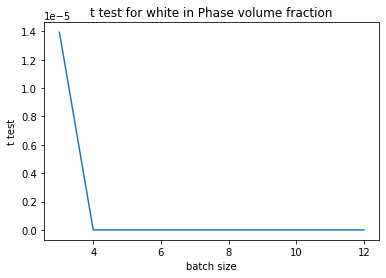

In [112]:
t_test_white = np.zeros(5)
t_test_white[0] = my_ttest(vf1[:,2],vf2[:,2])
t_test_white[1] = my_ttest(vf1[:,2],vf3[:,2])
t_test_white[2] = my_ttest(vf1[:,2],vf4[:,2])
t_test_white[3] = my_ttest(vf1[:,2],vf5[:,2])
t_test_white[4] = my_ttest(vf1[:,2],vf6[:,2])
x = [3,4,6,10,12]
plt.plot(x,t_test_white)
plt.title(u't test for white in Phase volume fraction')        
plt.xlabel('batch size')             
plt.ylabel('t test')

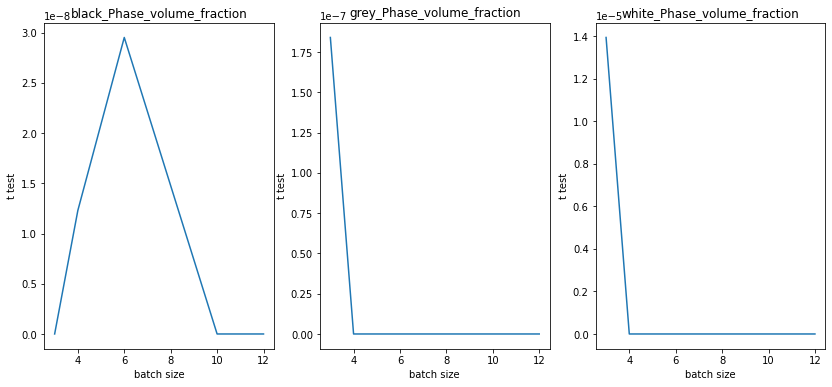

In [120]:
plt.figure(figsize=(14,6))
plt.subplot(131)
plt.plot(x,t_test_black)
plt.title(u'black_Phase_volume_fraction')        
plt.xlabel('batch size')             
plt.ylabel('t test')
plt.subplot(132)
plt.plot(x,t_test_grey)
plt.title(u'grey_Phase_volume_fraction')        
plt.xlabel('batch size')             
plt.ylabel('t test')
plt.subplot(133)
plt.plot(x,t_test_white)
plt.title(u'white_Phase_volume_fraction')        
plt.xlabel('batch size')             
plt.ylabel('t test')
plt.show()

## specific surface area

In [14]:
# calculate perimeter
def perimeter_greyscale(img):
  ret,thresh = cv2.threshold(img,127,255,0)
  contours,hierarchy = cv2.findContours(thresh, 1, 2)
  sum = 0
  for i in range(len(contours)):
      cnt = contours[i]
      perimeter = cv2.arcLength(cnt,True)
      sum = sum + perimeter
  return sum

In [15]:
# make black into white,to only calculate the perimeter of the black
def inverse_black(img): 
  img = img - 1
  img[img<255] = 0
  return img

# make grey into white,to only calculate the perimeter of the grey
def inverse_grey(img): 
  img = img - 129
  img[img<255] = 0
  return img


In [16]:
# calculate specific surface area
def specific_surface_area(vf,dicname,crop_size,voxel_size):
  i = 0 
  fac = np.zeros(shape=(3))
  for filename in os.listdir(r"/" + dicname): 
      img = color.rgb2gray(io.imread("/" + dicname + "/" + filename))         #rgb2grey
      img_shape = cv2.resize(img, crop_size, interpolation = cv2.INTER_CUBIC) #reshape
      fac = surface_greyscale(img_shape)
      vf[i,1] = (perimeter_greyscale(inverse_black(img_shape))*voxel_size)/(fac[0]*pow(voxel_size,3))
      vf[i,1] = (perimeter_greyscale(inverse_grey(img_shape))*voxel_size)/(fac[1]*pow(voxel_size,3))
      vf[i,2] = (perimeter_greyscale(img_shape)*voxel_size)/(fac[2]*pow(voxel_size,3))   #面积除以体积
      i = i + 1
  return vf

In [17]:
# calculate specific surface area
def specific_surface_area_fake(vf,dicname,crop_size,voxel_size):
  i = 0 
  fac = np.zeros(shape=(3))
  for filename in os.listdir(r"/" + dicname): 
      img = cv2.imread("/" + dicname + "/" + filename,cv2.CV_8UC1)
      img_shape = cv2.resize(img, crop_size, interpolation = cv2.INTER_CUBIC) #reshape
      img_shape[img_shape<120] = 0
      img_shape[img_shape>170] = 255
      img_shape[(img_shape<=170)&(img_shape>=120)] = 128  
      fac = surface_greyscale(img_shape)   
      vf[i,1] = (perimeter_greyscale(inverse_black(img_shape))*voxel_size)/(fac[0]*pow(voxel_size,3))
      vf[i,1] = (perimeter_greyscale(inverse_grey(img_shape))*voxel_size)/(fac[1]*pow(voxel_size,3))
      vf[i,2] = (perimeter_greyscale(img_shape)*voxel_size)/(fac[2]*pow(voxel_size,3))   #面积除以体积
      i = i + 1
  return vf

In [18]:
dicname1 = "content/drive/My Drive/Colab Notebooks/anode_segmented" #real image
dicname2 = "content/drive/My Drive/Colab Notebooks/syn_anode_size3" #fake image
dicname3 = "content/drive/My Drive/Colab Notebooks/syn_anode_size4" #fake image
dicname4 = "content/drive/My Drive/Colab Notebooks/syn_anode_size6" #fake image
dicname5 = "content/drive/My Drive/Colab Notebooks/syn_anode_size10" #fake image
dicname6 = "content/drive/My Drive/Colab Notebooks/syn_anode_size12" #fake image

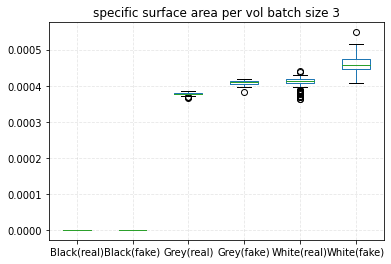

In [271]:
#plot specific surface area per vol box of the images(orininal or syn images)
files1=os.listdir("/" + dicname1) 
num_img1 = len(files1)
files2=os.listdir("/" + dicname2) 
num_img2 = len(files2)
vf1 = np.zeros(shape=(num_img1,3))
vf2 = np.zeros(shape=(num_img2,3))
crop_size = (224, 224)
voxel_size = 64
vf1 = specific_surface_area_fake(vf1,dicname1,crop_size,voxel_size)
vf2 = specific_surface_area_fake(vf2,dicname2,crop_size,voxel_size)
vf = np.hstack((vf1,vf2))
descrire = "specific surface area per vol batch size 3"
plot_box(vf,descrire)

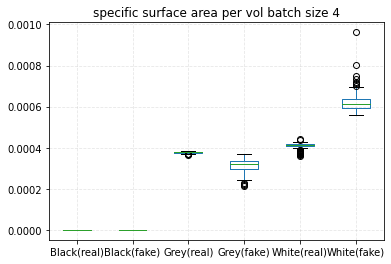

In [273]:
#plot volume fraction box of the images(orininal or syn images)
files1=os.listdir("/" + dicname1) 
num_img1 = len(files1)
files3=os.listdir("/" + dicname3) 
num_img3 = len(files3)
vf1 = np.zeros(shape=(num_img1,3))
vf3 = np.zeros(shape=(num_img3,3))
vf = np.zeros(shape=(num_img3,6))
crop_size = (224, 224)
voxel_size = 64
vf1 = specific_surface_area_fake(vf1,dicname1,crop_size,voxel_size)
vf3 = specific_surface_area_fake(vf3,dicname3,crop_size,voxel_size)
vf = np.hstack((vf1,vf3))
descrire = "specific surface area per vol batch size 4"
plot_box(vf,descrire)

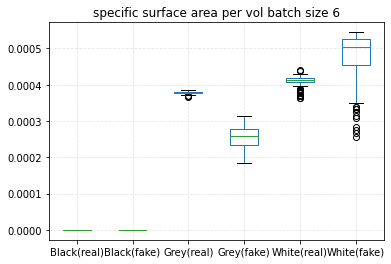

In [274]:
#plot volume fraction box of the images(orininal or syn images)
files1=os.listdir("/" + dicname1) 
num_img1 = len(files1)
files4=os.listdir("/" + dicname4) 
num_img4 = len(files4)
vf1 = np.zeros(shape=(num_img1,3))
vf4 = np.zeros(shape=(num_img4,3))
vf = np.zeros(shape=(num_img4,6))
crop_size = (224, 224)
voxel_size = 64
vf1 = specific_surface_area_fake(vf1,dicname1,crop_size,voxel_size)
vf4 = specific_surface_area_fake(vf4,dicname4,crop_size,voxel_size)
vf = np.hstack((vf1,vf4))
descrire = "specific surface area per vol batch size 6"
plot_box(vf,descrire)

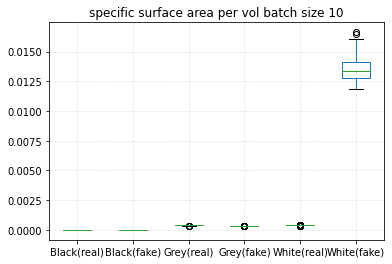

In [275]:
#plot volume fraction box of the images(orininal or syn images)
files1=os.listdir("/" + dicname1) 
num_img1 = len(files1)
files5=os.listdir("/" + dicname5) 
num_img5 = len(files5)
vf1 = np.zeros(shape=(num_img1,3))
vf5 = np.zeros(shape=(num_img5,3))
vf = np.zeros(shape=(num_img5,6))
crop_size = (224, 224)
voxel_size = 64
vf1 = specific_surface_area_fake(vf1,dicname1,crop_size,voxel_size)
vf5 = specific_surface_area_fake(vf5,dicname5,crop_size,voxel_size)
vf = np.hstack((vf1,vf5))
descrire = "specific surface area per vol batch size 10"
plot_box(vf,descrire)

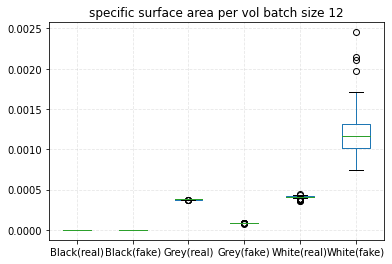

In [276]:
#plot volume fraction box of the images(orininal or syn images)
files1=os.listdir("/" + dicname1) 
num_img1 = len(files1)
files6=os.listdir("/" + dicname6) 
num_img6 = len(files6)
vf1 = np.zeros(shape=(num_img1,3))
vf6 = np.zeros(shape=(num_img6,3))
vf = np.zeros(shape=(num_img6,6))
crop_size = (224, 224)
voxel_size = 64
vf1 = specific_surface_area_fake(vf1,dicname1,crop_size,voxel_size)
vf6 = specific_surface_area_fake(vf6,dicname6,crop_size,voxel_size)
vf = np.hstack((vf1,vf6))
descrire = "specific surface area per vol batch size 12"
plot_box(vf,descrire)

4.709866968726138e-136
6.811848690918015e-60
2.1209593431468522e-109
3.6791267295671456e-95
0.0


Text(0, 0.5, 't test')

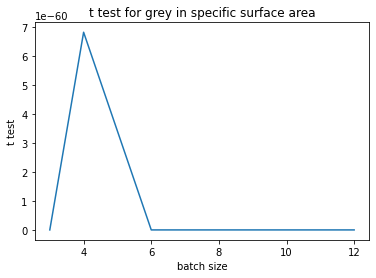

In [280]:
t_test_grey = np.zeros(5)
t_test_grey[0] = my_ttest(vf1[:,1],vf2[:,1])
t_test_grey[1] = my_ttest(vf1[:,1],vf3[:,1])
t_test_grey[2] = my_ttest(vf1[:,1],vf4[:,1])
t_test_grey[3] = my_ttest(vf1[:,1],vf5[:,1])
t_test_grey[4] = my_ttest(vf1[:,1],vf6[:,1])
x = [3,4,6,10,12]
plt.plot(x,t_test_grey)
plt.title(u't test for grey in specific surface area')        
plt.xlabel('batch size')             
plt.ylabel('t test')

4.829971146984235e-57
5.409446238490296e-119
2.6521401497684965e-20
2.768119049309742e-244
1.1320470784832734e-86


Text(0, 0.5, 't test')

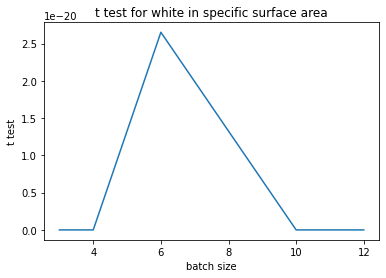

In [281]:
t_test_white = np.zeros(5)
t_test_white[0] = my_ttest(vf1[:,2],vf2[:,2])
t_test_white[1] = my_ttest(vf1[:,2],vf3[:,2])
t_test_white[2] = my_ttest(vf1[:,2],vf4[:,2])
t_test_white[3] = my_ttest(vf1[:,2],vf5[:,2])
t_test_white[4] = my_ttest(vf1[:,2],vf6[:,2])
x = [3,4,6,10,12]
plt.plot(x,t_test_white)
plt.title(u't test for white in specific surface area')        
plt.xlabel('batch size')             
plt.ylabel('t test')

## TPB


prepare for the data and save as mat, go for the matlab

In [19]:
import os
 
print(os.getcwd())
 
# change the work path
import os
from google.colab import drive
drive.mount('/content/drive')
 
path = "/content/drive/My Drive/Colab Notebooks"
os.chdir(path)

/content
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
dicname1 = "content/drive/My Drive/Colab Notebooks/anode_segmented" #real image
dicname2 = "content/drive/My Drive/Colab Notebooks/syn_anode_size3" #fake image
dicname3 = "content/drive/My Drive/Colab Notebooks/syn_anode_size4" #fake image
dicname4 = "content/drive/My Drive/Colab Notebooks/syn_anode_size6" #fake image
dicname5 = "content/drive/My Drive/Colab Notebooks/syn_anode_size10" #fake image
dicname6 = "content/drive/My Drive/Colab Notebooks/syn_anode_size12" #fake image

files=os.listdir("/" + dicname1) # change the dic name here
num_img1 = len(files)
train_images1 = np.zeros(shape=(num_img1,224,224))
crop_size = (224, 224)
train_images1 = read_data(train_images1,dicname1,crop_size) # change the dic name here

files=os.listdir("/" + dicname2) # change the dic name here
num_img2 = len(files)
train_images2 = np.zeros(shape=(num_img2,224,224))
crop_size = (224, 224)
train_images2 = read_data(train_images2,dicname2,crop_size) # change the dic name here

files=os.listdir("/" + dicname3) # change the dic name here
num_img3 = len(files)
train_images3 = np.zeros(shape=(num_img3,224,224))
crop_size = (224, 224)
train_images3 = read_data(train_images3,dicname3,crop_size) # change the dic name here

files=os.listdir("/" + dicname4) # change the dic name here
num_img4 = len(files)
train_images4 = np.zeros(shape=(num_img4,224,224))
crop_size = (224, 224)
train_images4 = read_data(train_images4,dicname4,crop_size) # change the dic name here

files=os.listdir("/" + dicname5) # change the dic name here
num_img5 = len(files)
train_images5 = np.zeros(shape=(num_img5,224,224))
crop_size = (224, 224)
train_images5 = read_data(train_images5,dicname5,crop_size) # change the dic name here

files=os.listdir("/" + dicname6) # change the dic name here
num_img6 = len(files)
train_images6 = np.zeros(shape=(num_img6,224,224))
crop_size = (224, 224)
train_images6 = read_data(train_images6,dicname6,crop_size) # change the dic name here

In [28]:
def turninto012(image):
  image[image<120] = 0
  image[image>170] = 1
  image[(image<=170)&(image>=120)] = 2
  return image

In [29]:
train_images1 = turninto012(train_images1)
train_images2 = train_images2*255
train_images2 = turninto012(train_images2)
train_images3 = train_images3*255
train_images3 = turninto012(train_images3)
train_images4 = train_images4*255
train_images4 = turninto012(train_images4)
train_images5 = train_images5*255
train_images5 = turninto012(train_images5)
train_images6 = train_images6*255
train_images6 = turninto012(train_images6)

In [33]:
#turin it into 4D
def image4D(num_img,image_set,fourDsize):
  images = np.zeros(shape=(num_img,224,224,fourDsize))
  for i in range(num_img):
    for j in range(fourDsize):
      images[i,:,:,j] = image_set[i,:,:]
  return images

In [34]:
image4D1 = image4D(num_img1,train_images1,5)
image4D2 = image4D(num_img2,train_images2,5)
image4D3 = image4D(num_img3,train_images3,5)
image4D4 = image4D(num_img4,train_images4,5)
image4D5 = image4D(num_img5,train_images5,5)
image4D6 = image4D(num_img6,train_images6,5)

In [32]:
#scio.savemat("fake_anode_SOFC.mat", {'fake': images1})
#scio.savemat("real_anode_SOFC.mat", {'real': images2})

### calculate TPB

In [35]:
def equal0(array):
  array[array==0] = 5
  array[array != 5] = 0
  array[array == 5] = 1
  return array

def not1(array):
  array[array==1] = 5
  array[array != 5] = 1
  array[array == 5] = 0
  return array

def not2(array):
  array[array==2] = 5
  array[array != 5] = 1
  array[array == 5] = 0 
  return array 


In [36]:
def tpb(image4D,voxel):
  a =np.zeros(image4D.shape[0])
  for i in range(image4D.shape[0]):
    S = image4D[i,:,:,:]
    x = S.shape[0]
    y = S.shape[1]
    z = S.shape[2]
    C0 = np.zeros(shape=(x,y,z))
    C1 = np.zeros(shape=(x,y,z))
    C2 = np.zeros(shape=(x,y,z))
    S1 = equal0(S) + not1(S)
    S2 = equal0(S) + not2(S)

    for l in range(S.shape[0]-1):
      for j in range(S.shape[1]-1):
        for k in range(S.shape[2]-1):
          C0[l,j,k] = S[l,j,k]*S[l+1,j,k]*S[l,j+1,k]*S[l+1,j+1,k]*S[l,j,k+1]*S[l+1,j,k+1]*S[l,j+1,k+1]*S[l+1,j+1,k+1]
          C1[l,j,k] = S1[l,j,k]*S1[l+1,j,k]*S1[l,j+1,k]*S1[l+1,j+1,k]*S1[l,j,k+1]*S1[l+1,j,k+1]*S1[l,j+1,k+1]*S1[l+1,j+1,k+1]
          C2[l,j,k] = S2[l,j,k]*S2[l+1,j,k]*S2[l,j+1,k]*S2[l+1,j+1,k]*S2[l,j,k+1]*S2[l+1,j,k+1]*S2[l,j+1,k+1]*S2[l+1,j+1,k+1]

    CFF = C0+C1+C2
    ltpb = CFF.sum()/((S.shape[0])*(S.shape[1])*(S.shape[2])*1.455*pow(voxel,2))
    a[i] = round(ltpb,5)
  return a

In [37]:
def plot_box_tpb(vf,descrire):

  data = {
  'fake TPB density': vf[0,:],
  'real TPB density': vf[1,:],
    }
  df = pd.DataFrame(data)
  df.plot.box(title=descrire)
  plt.grid(linestyle="--", alpha=0.3)
  plt.show()

In [38]:
tpb1 = tpb(image4D1,65)


In [39]:
tpb2 = tpb(image4D2,65)

In [40]:
tpb3 = tpb(image4D3,65)
tpb4 = tpb(image4D4,65)
tpb5 = tpb(image4D5,65)
tpb6 = tpb(image4D6,65)

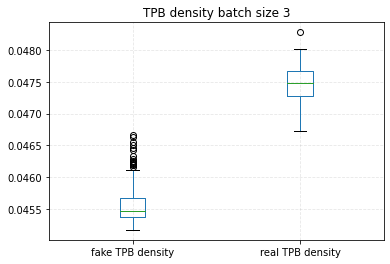

In [41]:
tpb = np.vstack((tpb1,tpb2))
describe = "TPB density batch size 3"
plot_box_tpb(tpb,describe)

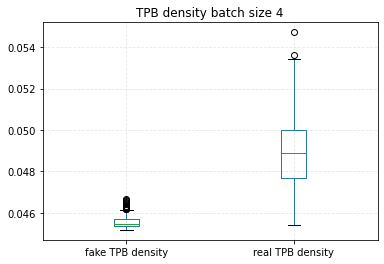

In [42]:
tpb = np.vstack((tpb1,tpb3))
describe = "TPB density batch size 4"
plot_box_tpb(tpb,describe)

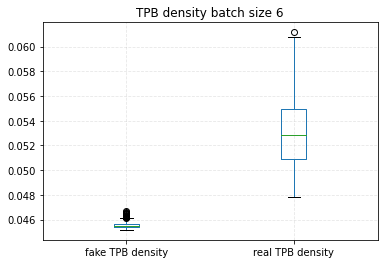

In [43]:
tpb = np.vstack((tpb1,tpb4))
describe = "TPB density batch size 6"
plot_box_tpb(tpb,describe)

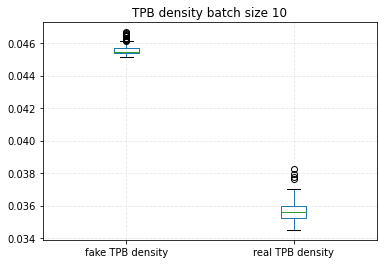

In [44]:
tpb = np.vstack((tpb1,tpb5))
describe = "TPB density batch size 10"
plot_box_tpb(tpb,describe)

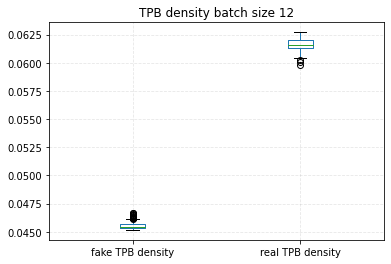

In [45]:
tpb = np.vstack((tpb1,tpb6))
describe = "TPB density batch size 12"
plot_box_tpb(tpb,describe)

In [71]:
def plot_box_tpb_total(vf,descrire):

  data = {
  'real TPB density': vf[0,:],
  'fake TPB density(size 3)': vf[1,:],
  'fake TPB density(size 4)': vf[2,:],
  'fake TPB density(size 6)': vf[3,:],
  'fake TPB density(size 10)': vf[4,:],
  'fake TPB density(size 12)': vf[5,:],  
    }
  df = pd.DataFrame(data)
  df.plot.box(title=descrire)
  plt.grid(linestyle="--", alpha=0.3)
  plt.tick_params(axis='x', labelsize=8)
  plt.xticks(rotation=-25) 
  plt.show()

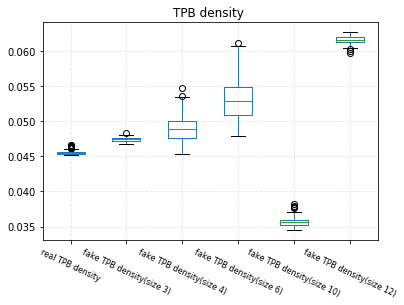

In [72]:
tpb = np.vstack((tpb1,tpb2,tpb3,tpb4,tpb5,tpb6,))
describe = "TPB density "
plot_box_tpb_total(tpb,describe)

5.817906825198551e-120
9.949906588751668e-56
8.51663141458397e-71
1.2679431797772226e-242
9.1480832918598e-310


Text(0, 0.5, 't test')

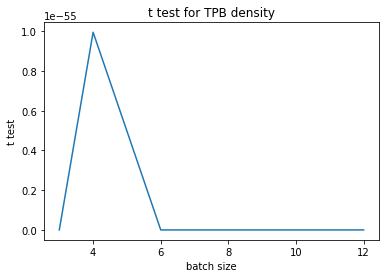

In [48]:
t_test_tpb = np.zeros(5)
t_test_tpb[0] = my_ttest(tpb1,tpb2)
t_test_tpb[1] = my_ttest(tpb1,tpb3)
t_test_tpb[2] = my_ttest(tpb1,tpb4)
t_test_tpb[3] = my_ttest(tpb1,tpb5)
t_test_tpb[4] = my_ttest(tpb1,tpb6)
x = [3,4,6,10,12]
plt.plot(x,t_test_tpb)
plt.title(u't test for TPB density')        
plt.xlabel('batch size')             
plt.ylabel('t test')

## Next steps


This tutorial has shown the complete code necessary to write and train a GAN. As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset [available on Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset). To learn more about GANs we recommend the [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160).
